# Task 3 - Modeling

## Import

In [26]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

In [2]:
def load_and_clean_data(filename):
    df = pd.read_csv(filename)
    df.drop(columns=["Unnamed: 0"], inplace=True, errors='ignore')
    return df

In [3]:
sales_df = load_and_clean_data("sales.csv")
stock_df = load_and_clean_data("sensor_stock_levels.csv")
temp_df = load_and_clean_data("sensor_storage_temperature.csv")

In [4]:
dataframes = [sales_df,stock_df,temp_df]

In [5]:
for df in dataframes:
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7829 entries, 0 to 7828
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   transaction_id  7829 non-null   object 
 1   timestamp       7829 non-null   object 
 2   product_id      7829 non-null   object 
 3   category        7829 non-null   object 
 4   customer_type   7829 non-null   object 
 5   unit_price      7829 non-null   float64
 6   quantity        7829 non-null   int64  
 7   total           7829 non-null   float64
 8   payment_type    7829 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 550.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   15000 non-null  object 
 1   timestamp            15000 non-null  object 
 2   product_id       

In [6]:
# Define a function to convert timestamp to hourly format
def convert_timestamp_to_hourly(data: pd.DataFrame, column: str):
    data[column] = pd.to_datetime(data[column]).dt.strftime('%Y-%m-%d %H:00:00')
    data[column] = pd.to_datetime(data[column])
    return data

In [7]:
# Convert timestamps to hourly format
timestamp_columns = ['timestamp']
for df in dataframes:
    for col in timestamp_columns:
        df = convert_timestamp_to_hourly(df, col)

In [8]:
for df in dataframes:
    print(df.head())

                         transaction_id           timestamp  \
0  a1c82654-c52c-45b3-8ce8-4c2a1efe63ed 2022-03-02 09:00:00   
1  931ad550-09e8-4da6-beaa-8c9d17be9c60 2022-03-06 10:00:00   
2  ae133534-6f61-4cd6-b6b8-d1c1d8d90aea 2022-03-04 17:00:00   
3  157cebd9-aaf0-475d-8a11-7c8e0f5b76e4 2022-03-02 17:00:00   
4  a81a6cd3-5e0c-44a2-826c-aea43e46c514 2022-03-05 14:00:00   

                             product_id category customer_type  unit_price  \
0  3bc6c1ea-0198-46de-9ffd-514ae3338713    fruit          gold        3.99   
1  ad81b46c-bf38-41cf-9b54-5fe7f5eba93e    fruit      standard        3.99   
2  7c55cbd4-f306-4c04-a030-628cbe7867c1    fruit       premium        0.19   
3  80da8348-1707-403f-8be7-9e6deeccc883    fruit          gold        0.19   
4  7f5e86e6-f06f-45f6-bf44-27b095c9ad1d    fruit         basic        4.49   

   quantity  total payment_type  
0         2   7.98     e-wallet  
1         1   3.99     e-wallet  
2         2   0.38     e-wallet  
3         4   0.

In [9]:
# Merge data
product_categories = sales_df[['product_id', 'category']].drop_duplicates()
product_price = sales_df[['product_id', 'unit_price']].drop_duplicates()

sales_agg = sales_df.groupby(['timestamp', 'product_id']).agg({'quantity': 'sum'}).reset_index()
stock_agg = stock_df.groupby(['timestamp', 'product_id']).agg({'estimated_stock_pct': 'mean'}).reset_index()
temp_agg = temp_df.groupby(['timestamp']).agg({'temperature': 'mean'}).reset_index()

merged_df = stock_agg.merge(sales_agg, on=['timestamp', 'product_id'], how='left')
merged_df = merged_df.merge(temp_agg, on='timestamp', how='left')
merged_df = merged_df.merge(product_categories, on="product_id", how="left")
merged_df = merged_df.merge(product_price, on="product_id", how="left")

In [10]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10845 entries, 0 to 10844
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   timestamp            10845 non-null  datetime64[ns]
 1   product_id           10845 non-null  object        
 2   estimated_stock_pct  10845 non-null  float64       
 3   quantity             3067 non-null   float64       
 4   temperature          10845 non-null  float64       
 5   category             10845 non-null  object        
 6   unit_price           10845 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 677.8+ KB


In [11]:
# Fill null values in 'quantity' column with 0
merged_df['quantity'] = merged_df['quantity'].fillna(0)

merged_df.head()

,timestamp,product_id,estimated_stock_pct,quantity,temperature,category,unit_price
0,2022-03-01 09:00:00,00e120bb-89d6-4df5-bc48-a051148e3d03,0.89,3.0,-0.02885,kitchen,11.19
1,2022-03-01 09:00:00,01f3cdd9-8e9e-4dff-9b5c-69698a0388d0,0.14,3.0,-0.02885,vegetables,1.49
2,2022-03-01 09:00:00,01ff0803-ae73-4234-971d-5713c97b7f4b,0.67,0.0,-0.02885,baby products,14.19
3,2022-03-01 09:00:00,0363eb21-8c74-47e1-a216-c37e565e5ceb,0.82,0.0,-0.02885,beverages,20.19
4,2022-03-01 09:00:00,03f0b20e-3b5b-444f-bc39-cdfa2523d4bc,0.05,0.0,-0.02885,pets,8.19


In [12]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10845 entries, 0 to 10844
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   timestamp            10845 non-null  datetime64[ns]
 1   product_id           10845 non-null  object        
 2   estimated_stock_pct  10845 non-null  float64       
 3   quantity             10845 non-null  float64       
 4   temperature          10845 non-null  float64       
 5   category             10845 non-null  object        
 6   unit_price           10845 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 677.8+ KB


## Explore

In [13]:
merged_df.describe()

,estimated_stock_pct,quantity,temperature,unit_price
count,10845.000000,10845.000000,10845.000000,10845.000000
mean,0.505130,0.908529,-0.213678,8.938575
std,0.264519,1.787680,0.649671,5.390235
min,0.010000,0.000000,-1.847270,0.190000
25%,0.300000,0.000000,-0.657082,4.990000
50%,0.500000,0.000000,-0.230631,8.190000
75%,0.715000,1.000000,0.160429,12.490000
max,1.000000,15.000000,1.435938,23.990000


## Insights

### estimated_stock_pct
- The estimated stock percentage varies from a minimum of 0.01 to a maximum of 1.00.
- On average, the estimated stock percentage is approximately 0.51.
- The standard deviation of the estimated stock percentage is 0.26, indicating moderate variability.

### quantity
- The quantity of products purchased ranges from a minimum of 0 to a maximum of 15.
- On average, the quantity purchased is around 0.91 units.
- The data is right-skewed, as indicated by the median (50%) being 0, while the mean is higher.

### temperature
- The temperature values range from approximately -1.85 to 1.44.
- On average, the temperature has a negative value of around -0.21.
- The distribution of temperature appears to be centered around the negative range.

### unit_price
- The unit prices of products range from 0.19 to 23.99.
- The average unit price is about 8.94.
- There is noticeable variability in unit prices, with a relatively high standard deviation of 5.39.

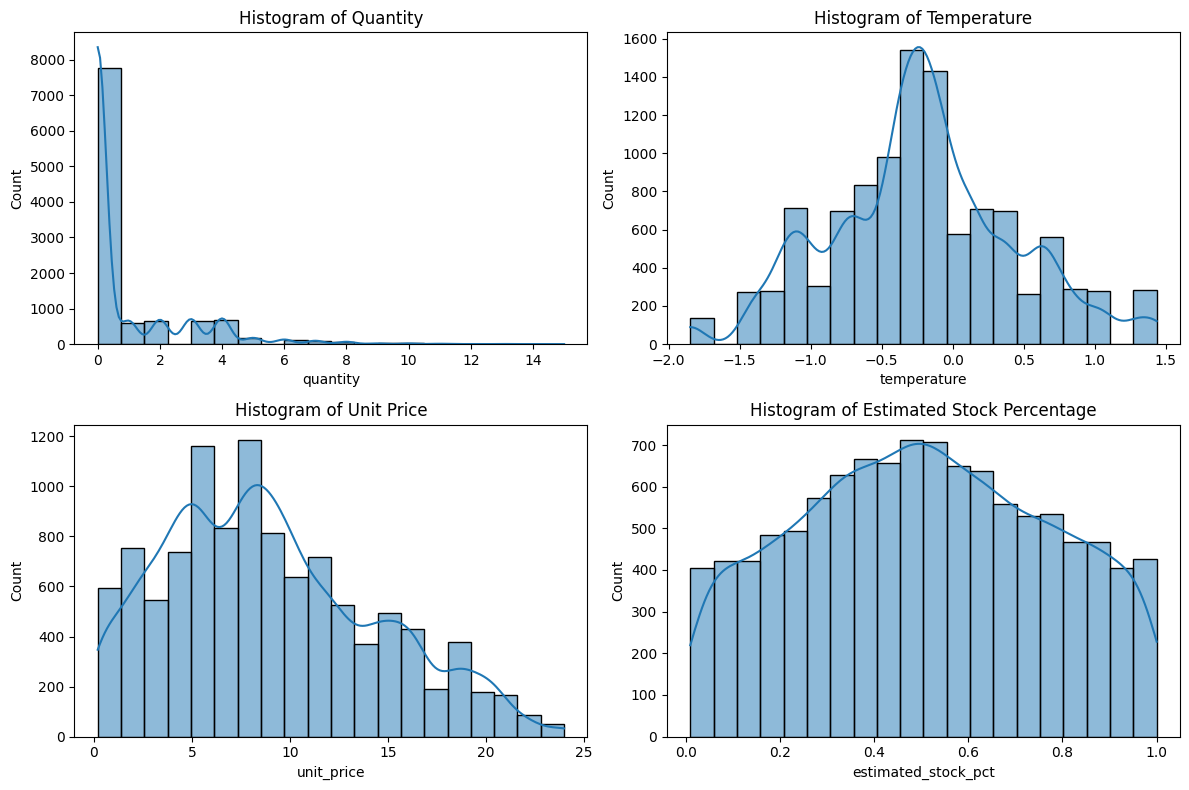

In [14]:
# Set up the figure and axes
plt.figure(figsize=(12, 8))

# Plot histogram for 'quantity'
plt.subplot(2, 2, 1)
sns.histplot(data=merged_df, x='quantity', bins=20, kde=True)
plt.title('Histogram of Quantity')

# Plot histogram for 'temperature'
plt.subplot(2, 2, 2)
sns.histplot(data=merged_df, x='temperature', bins=20, kde=True)
plt.title('Histogram of Temperature')

# Plot histogram for 'unit_price'
plt.subplot(2, 2, 3)
sns.histplot(data=merged_df, x='unit_price', bins=20, kde=True)
plt.title('Histogram of Unit Price')

# Plot histogram for 'estimated_stock_pct'
plt.subplot(2, 2, 4)
sns.histplot(data=merged_df, x='estimated_stock_pct', bins=20, kde=True)
plt.title('Histogram of Estimated Stock Percentage')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

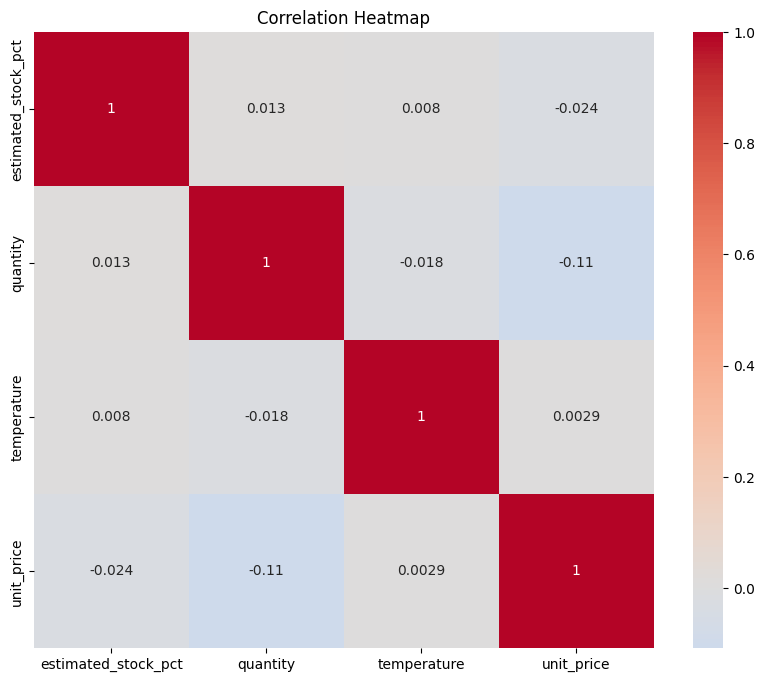

In [15]:
correlation_matrix = merged_df.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

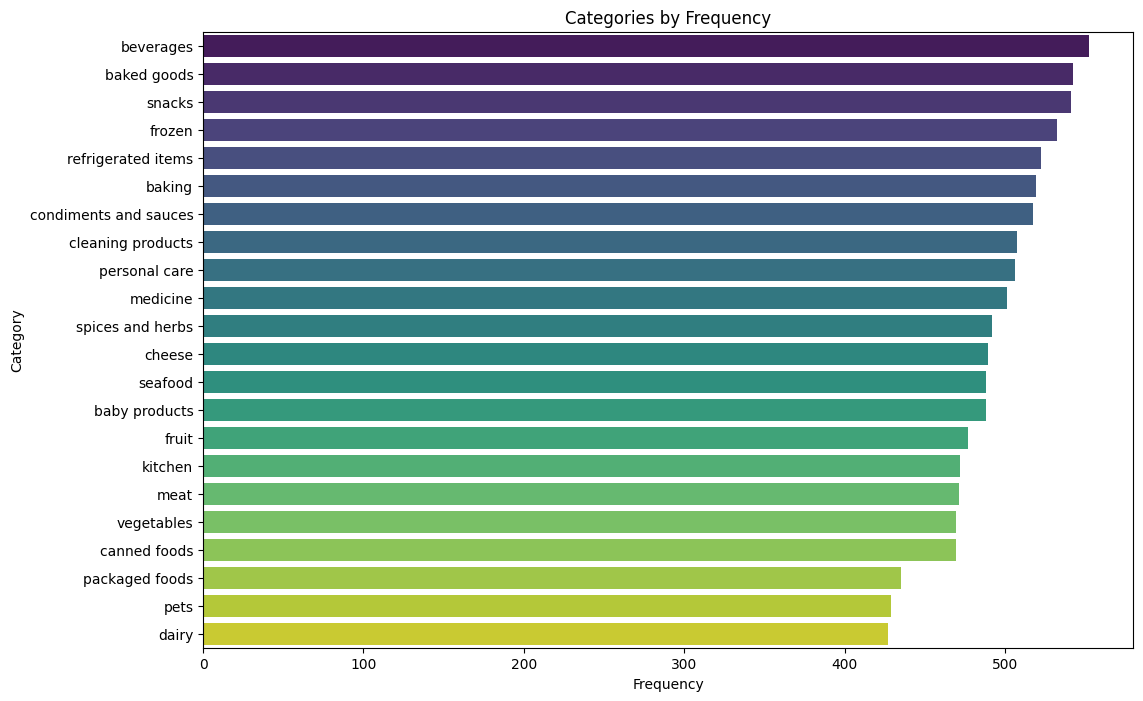

In [16]:
# Get the categories based on frequency
top_categories = merged_df['category'].value_counts()

plt.figure(figsize=(12, 8))
sns.barplot(x=top_categories.values, y=top_categories.index, palette='viridis')
plt.xlabel('Frequency')
plt.ylabel('Category')
plt.title('Categories by Frequency')
plt.show()

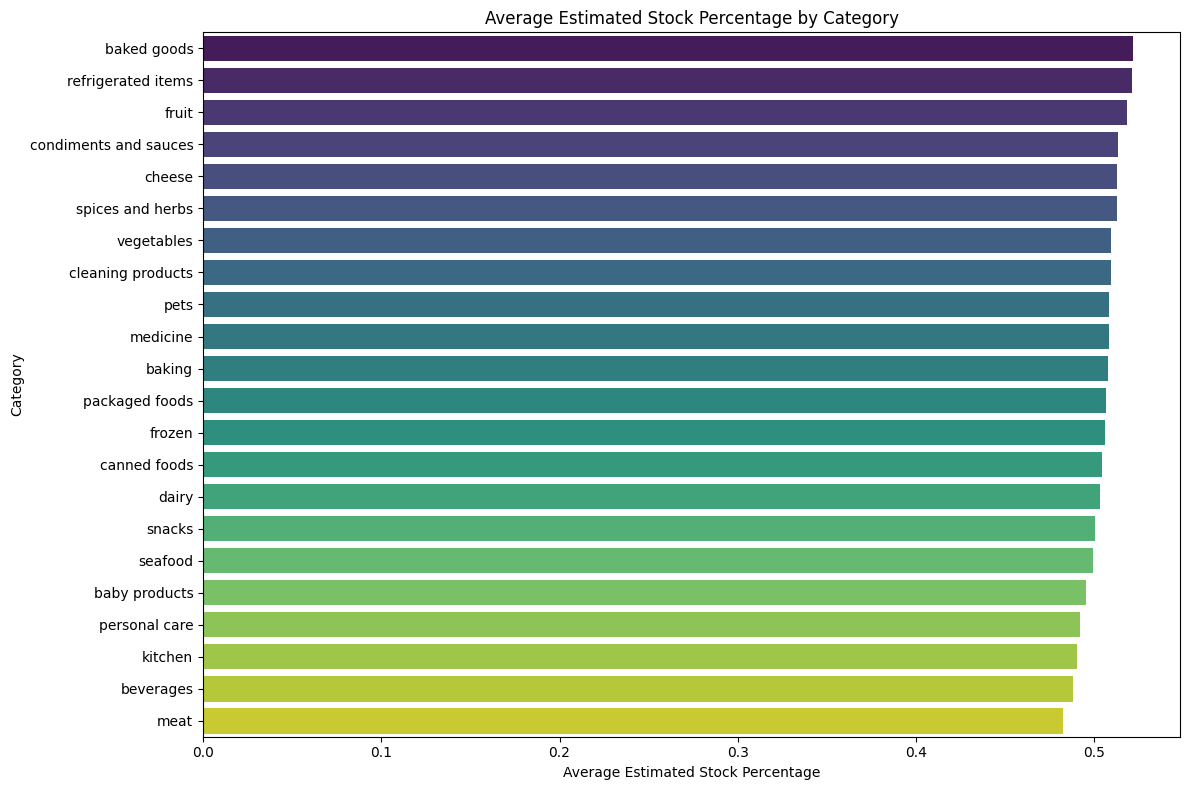

In [17]:
# Calculate the average estimated stock percentage for each category
category_avg_stock = merged_df.groupby('category')['estimated_stock_pct'].mean().sort_values(ascending=False)

# Select the top 20 categories with higher average stock percentages
top_categories = category_avg_stock

# Set up the figure and axes
plt.figure(figsize=(12, 8))

# Create a bar plot for the average stock percentage by category
sns.barplot(x=top_categories.values, y=top_categories.index, palette='viridis')
plt.title('Average Estimated Stock Percentage by Category')
plt.xlabel('Average Estimated Stock Percentage')
plt.ylabel('Category')

# Show the plot
plt.tight_layout()
plt.show()

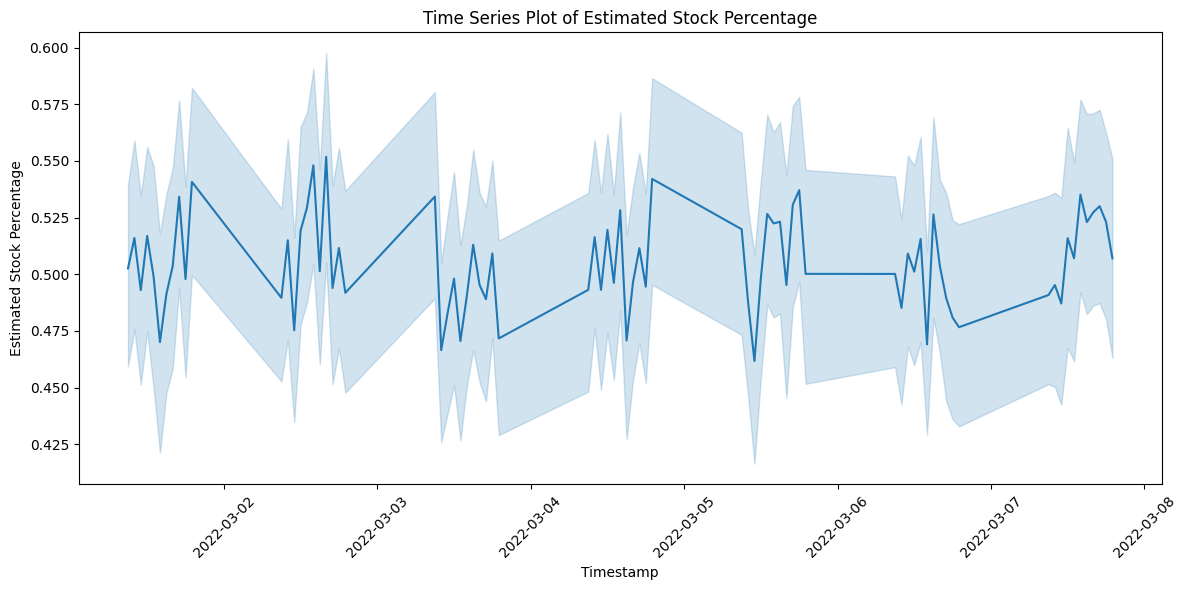

In [18]:
# Set up the figure and axes
plt.figure(figsize=(12, 6))

# Create a time series plot
sns.lineplot(data=merged_df, x='timestamp', y='estimated_stock_pct')
plt.title('Time Series Plot of Estimated Stock Percentage')
plt.xlabel('Timestamp')
plt.ylabel('Estimated Stock Percentage')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

In [19]:
merged_df["product_id"].nunique()

300

In [20]:
merged_df = pd.get_dummies(merged_df, columns=['category']) # one-hot encoding for cat. data
merged_df.drop(columns=['product_id'], inplace=True) # not very predictive, we can remove
merged_df.head()

,timestamp,estimated_stock_pct,quantity,temperature,unit_price,category_baby products,category_baked goods,category_baking,category_beverages,category_canned foods,...,category_meat,category_medicine,category_packaged foods,category_personal care,category_pets,category_refrigerated items,category_seafood,category_snacks,category_spices and herbs,category_vegetables
0,2022-03-01 09:00:00,0.89,3.0,-0.02885,11.19,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022-03-01 09:00:00,0.14,3.0,-0.02885,1.49,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2022-03-01 09:00:00,0.67,0.0,-0.02885,14.19,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2022-03-01 09:00:00,0.82,0.0,-0.02885,20.19,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,2022-03-01 09:00:00,0.05,0.0,-0.02885,8.19,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [21]:
# Extract day, hour, and day of the week from timestamp
merged_df['day'] = merged_df['timestamp'].dt.day
merged_df['hour'] = merged_df['timestamp'].dt.hour
merged_df['day_of_week'] = merged_df['timestamp'].dt.dayofweek

# Drop the original timestamp column
merged_df.drop(columns=['timestamp'], inplace=True)

In [22]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10845 entries, 0 to 10844
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   estimated_stock_pct             10845 non-null  float64
 1   quantity                        10845 non-null  float64
 2   temperature                     10845 non-null  float64
 3   unit_price                      10845 non-null  float64
 4   category_baby products          10845 non-null  uint8  
 5   category_baked goods            10845 non-null  uint8  
 6   category_baking                 10845 non-null  uint8  
 7   category_beverages              10845 non-null  uint8  
 8   category_canned foods           10845 non-null  uint8  
 9   category_cheese                 10845 non-null  uint8  
 10  category_cleaning products      10845 non-null  uint8  
 11  category_condiments and sauces  10845 non-null  uint8  
 12  category_dairy                  

# Build Model

## Split

In [23]:
# Prepare the data: X contains the features, y contains the target
X = merged_df.drop(columns=['estimated_stock_pct'])  # Exclude the target column
y = merged_df['estimated_stock_pct']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Baseline

In [28]:
y_mean = y_train.mean()
y_baseline = [y_mean]*len(y_train)
y_baseline_mae = mean_absolute_error(y_baseline,y_train)
print("Mean estimated_stock_pct:", y_mean.round(2))
print("Baseline MAE:", y_baseline_mae.round(2))

Mean estimated_stock_pct: 0.5
Baseline MAE: 0.22


In [29]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [30]:
# Initialize the model
rf_model = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

In [31]:
# Perform the grid search
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [32]:
# Get the best parameters and best model from grid search
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
test_predictions = best_model.predict(X_test)

In [34]:
# Calculate evaluation metrics (e.g., RMSE, MAE)
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = mean_squared_error(y_test, test_predictions, squared=False)
mae = mean_absolute_error(y_test, test_predictions)

print("Best Parameters:", best_params)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae.round(2))

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Root Mean Squared Error: 0.2653339352184794
Mean Absolute Error: 0.22


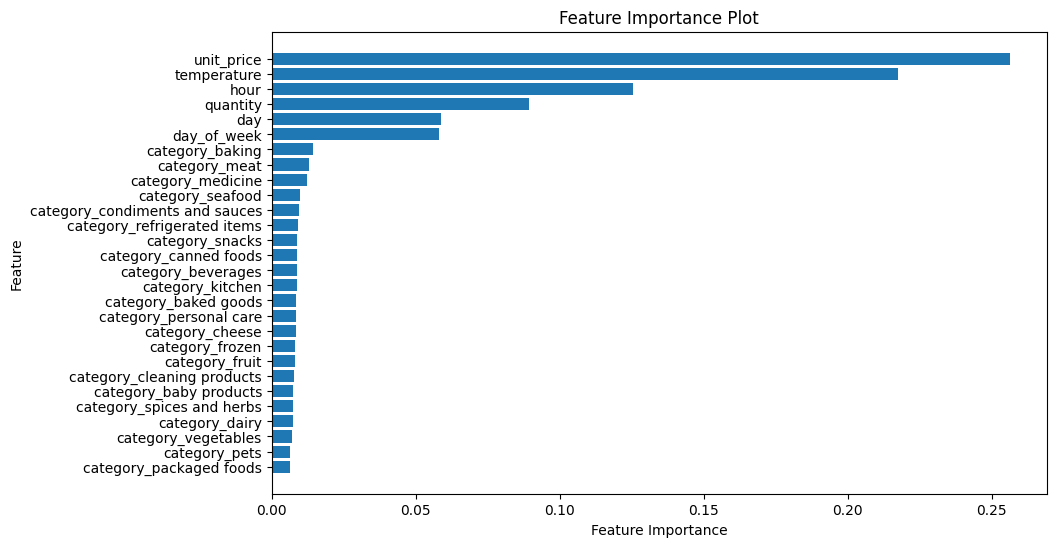

In [37]:
# Get feature importances from the best model
feature_importances = best_model.feature_importances_

# Combine feature names with their importances
feature_importance_dict = dict(zip(X.columns, feature_importances))

# Sort the features by importance in descending order
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1])

# Extract feature names and importance values for plotting
feature_names = [feature[0] for feature in sorted_features]
importance_values = [feature[1] for feature in sorted_features]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importance_values)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot')
plt.show()

In [38]:
# Print the list of feature importance values and their names
for feature_name, importance_value in sorted_features:
    print(f"Feature: {feature_name}, Importance: {importance_value}")

Feature: category_packaged foods, Importance: 0.006243524167204436
Feature: category_pets, Importance: 0.006505972067987093
Feature: category_vegetables, Importance: 0.0071073120092498615
Feature: category_dairy, Importance: 0.007286399704702039
Feature: category_spices and herbs, Importance: 0.007395877683456258
Feature: category_baby products, Importance: 0.007538331203903617
Feature: category_cleaning products, Importance: 0.007868690284869499
Feature: category_fruit, Importance: 0.00793641583500182
Feature: category_frozen, Importance: 0.0080972004004046
Feature: category_cheese, Importance: 0.0083538624203175
Feature: category_personal care, Importance: 0.008490537711657559
Feature: category_baked goods, Importance: 0.00856630984817438
Feature: category_kitchen, Importance: 0.008643813913643928
Feature: category_beverages, Importance: 0.008806232819218253
Feature: category_canned foods, Importance: 0.008855213818759837
Feature: category_snacks, Importance: 0.008858392602100513
Fea

## Data Analysis and Modeling Summary

### Data Preparation
- Merged three dataframes: sales, stock levels, and temperature data.
- Converted timestamps to hourly format for consistency.
- Extracted features such as day, hour, and day of the week from the timestamp.
- Encoded categorical variables using one-hot encoding.

### Data Exploration
- Explored the distributions of variables including estimated stock percentage, quantity, temperature, and unit price.
- Calculated statistics for insights, including mean, median, and variability.

### Modeling
- Built a Random Forest Regressor model to predict estimated stock percentage.
- Performed hyperparameter tuning using GridSearchCV for optimal model parameters.
- Evaluated the model's performance on the test set using RMSE and MAE metrics.

### Results
- Baseline MAE: 0.22 (using mean estimated stock percentage).
- Optimized Random Forest model achieved:
  - Best parameters: max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=200.
  - Root Mean Squared Error: 0.27.
  - Mean Absolute Error: 0.22.

### Feature Importance
- Feature importance analysis showed the most influential features:
  - unit_price, temperature, hour, quantity, day_of_week.
  - Categories, such as meat, medicine, and baking, also contributed to the model.

### Insights
- Temperature and unit price have the highest impact on estimated stock percentage.
- The model captured patterns related to time (hour, day_of_week), quantity, and specific product categories.
